# Clean Data

## Importing the Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import gzip
from io import StringIO
%matplotlib inline

In [2]:
# This function uses try statements to push through errors and unzip the csv data
def unzip_csv(file_location): 
    file = gzip.open(file_location, 'rb')
    content = file.read()
    file.close()
    try:
        content_str = str(content,'utf-8')
        content_data = StringIO(content_str) 
    except:
        content_str = str(content,'latin-1')
        content_data = StringIO(content_str) 
    try:
        return pd.read_csv(content_data)
    except:
        return pd.read_csv(content_data, sep='\t')

In [3]:
#for copy paste purposes
!ls -la zippedData/

total 91432
drwxr-xr-x  13 cezine  staff       416 Jun 20 21:28 .
drwxr-xr-x  12 cezine  staff       384 Jun 21 20:23 ..
-rw-r--r--   1 cezine  staff     53544 Jun 20 21:28 bom.movie_gross.csv.gz
-rw-r--r--   1 cezine  staff  18070960 Jun 20 21:28 imdb.name.basics.csv.gz
-rw-r--r--   1 cezine  staff   5599979 Jun 20 21:28 imdb.title.akas.csv.gz
-rw-r--r--   1 cezine  staff   3459897 Jun 20 21:28 imdb.title.basics.csv.gz
-rw-r--r--   1 cezine  staff   1898523 Jun 20 21:28 imdb.title.crew.csv.gz
-rw-r--r--   1 cezine  staff  12287583 Jun 20 21:28 imdb.title.principals.csv.gz
-rw-r--r--   1 cezine  staff    539530 Jun 20 21:28 imdb.title.ratings.csv.gz
-rw-r--r--   1 cezine  staff    498202 Jun 20 21:28 rt.movie_info.tsv.gz
-rw-r--r--   1 cezine  staff   3402194 Jun 20 21:28 rt.reviews.tsv.gz
-rw-r--r--   1 cezine  staff    827840 Jun 20 21:28 tmdb.movies.csv.gz
-rw-r--r--   1 cezine  staff    153218 Jun 20 21:28 tn.movie_budgets.csv.gz


In [4]:
#hard-coding the file-locations and nicknames into a dict for future reference
#Console commands like !ls -la zippedData give a great place to copy pase this

file_locations = [
    'zippedData/bom.movie_gross.csv.gz'
    ,'zippedData/imdb.name.basics.csv.gz'
    ,'zippedData/imdb.title.akas.csv.gz'
    ,'zippedData/imdb.title.basics.csv.gz'
    ,'zippedData/imdb.title.crew.csv.gz'
    ,'zippedData/imdb.title.principals.csv.gz'
    ,'zippedData/imdb.title.ratings.csv.gz'
    ,'zippedData/rt.movie_info.tsv.gz'
    ,'zippedData/rt.reviews.tsv.gz'
    ,'zippedData/tmdb.movies.csv.gz'
    ,'zippedData/tn.movie_budgets.csv.gz'
]

file_nicknames = [
    'gross'
    ,'name'
    ,'akas'
    ,'basics'
    ,'crew'
    ,'principals'
    ,'ratings'
    ,'info'
    ,'reviews'
    ,'movies'
    ,'budget']


#this dicitonary comprehension uses a zip function to smush the two lists together and then parse them into a dict
#we also have a reference for each raw df and its location on the drive.

file_dict = {k:v for k,v in zip(file_nicknames,file_locations)}

In [5]:
#Importing all the data, commented out data we didn't use

#gross = unzip_csv(file_dict['gross'])
name = unzip_csv(file_dict['name'])
#akas = unzip_csv(file_dict['akas'])
basics = unzip_csv(file_dict['basics'])
#crew = unzip_csv(file_dict['crew'])
#principals = unzip_csv(file_dict['principals'])
#ratings = unzip_csv(file_dict['ratings'])
#info = unzip_csv(file_dict['info'])
#reviews = unzip_csv(file_dict['reviews'])
#movies = unzip_csv(file_dict['movies'])
budgets = unzip_csv(file_dict['budget'])

## Cleaning the Data

# Dataframe 'budgets'

In [6]:
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [7]:
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [8]:
#id column is a redundant index so we're dropping it

budgets.drop('id', axis=1, inplace=True)

In [9]:
#setting date column to datatime object for use in charts etc.

#budgets['release_date'] = pd.to_datetime(budgets['release_date'])

In [10]:
#stripping any unseen or unknown whitespace from the object locales

budgets.columns.str.strip()
budgets['movie'] = budgets['movie'].str.strip()

In [11]:
#this function launders the money ;D

def clean_money(budgets_series):
    #the map function applys the .replace to each cell in the given series, x[1:] skips the $
    
    return budgets_series.map(lambda x: int(x[1:].replace(',','')))

In [12]:
budgets['production_budget'] = clean_money(budgets['production_budget'])
budgets['domestic_gross'] = clean_money(budgets['domestic_gross'])
budgets['worldwide_gross'] = clean_money(budgets['worldwide_gross']);

In [13]:
#looks good

budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   int64 
 3   domestic_gross     5782 non-null   int64 
 4   worldwide_gross    5782 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 226.0+ KB


# Dataframe 'basics'

In [14]:
basics.head()

,tconst,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [15]:
basics.columns

Index(['tconst', 'primary_title', 'original_title', 'start_year',
       'runtime_minutes', 'genres'],
      dtype='object')

In [16]:
basics['movie'] = basics['primary_title']

In [17]:
#we only wanted genres titles, and ttconst for matching to the other file

basics.drop(['primary_title','original_title','start_year'
                ,'runtime_minutes'],axis=1,inplace=True)

In [18]:
basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tconst  146144 non-null  object
 1   genres  140736 non-null  object
 2   movie   146144 non-null  object
dtypes: object(3)
memory usage: 3.3+ MB


In [19]:
#the strip functions remove unwanted whitespace if its lurking in there

basics.columns = basics.columns.str.strip()

for column in list(basics.columns):
    basics[column] = basics[column].str.strip()

In [20]:
#the dataframe below proivdes a list of indices that contain a null value in the genre column
#the genre column is very important to our analysis so we'll drop null values

to_drop = basics[basics['genres'].isna()==True].index


#simple drop function will finish the job

basics.drop(to_drop,inplace=True)

In [21]:
#this .map will apply a .split to all the genres at each "," creating lists within the df

basics['genres'] = basics['genres'].map(lambda x: x.split(","))

In [22]:
basics['genres'][0]

['Action', 'Crime', 'Drama']

In [23]:
basics['genres'][0][1]

'Crime'

# Dataframe 'name'

In [24]:
name.head()

,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer","tt0837562,tt2398241,tt0844471,tt0118553"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department","tt0896534,tt6791238,tt0287072,tt1682940"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer","tt1470654,tt0363631,tt0104030,tt0102898"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department","tt0114371,tt2004304,tt1618448,tt1224387"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator","tt0452644,tt0452692,tt3458030,tt2178256"


In [25]:
#dropping these since they're outside the scope of our analysis

name.drop(['nconst','birth_year','death_year',],axis=1,inplace=True)

In [26]:
name.isnull().sum()

primary_name              0
primary_profession    51340
known_for_titles      30204
dtype: int64

In [27]:
#this phrase finds null values in either column

to_drop = name[(name['primary_profession'].isna()==True)|
               name['known_for_titles'].isna()==True].index

In [28]:
name.drop(to_drop,inplace=True)

In [29]:
#splitting the nested data

name['known_for_titles'] = name['known_for_titles'].map(lambda x: x.split(","))
name['primary_profession'] = name['primary_profession'].map(lambda x: x.split(","));

In [30]:
name['known_for_titles'][0][0]              

'tt0837562'

# Sejin's work starts here

In [31]:
###Exploring 'budgets' dataframe

In [32]:
budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


In [33]:
#Checking duplicates
budgets.duplicated().value_counts()

False    5782
dtype: int64

In [34]:
#Checking missing data
budgets.isna().sum()

release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [35]:
#Commented Shane's date format and creating 'release_year' column
budgets['release_year'] = budgets['release_date'].map(lambda x: x[-4:])

In [36]:
print(f'This data includes movies from {budgets.release_year.min()} to {budgets.release_year.max()}.')

This data includes movies from 1915 to 2020.


In [37]:
#Updating 'budgets' dataframe by filtering out years to get the lastest 10 years
budgets = budgets.loc[budgets['release_year'] > '2010']
budgets.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019
3,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015
4,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017
5,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015


In [38]:
###Merging'basics' and 'budgets' dataframes

In [39]:
basics.head(2)

,tconst,genres,movie
0,tt0063540,"[Action, Crime, Drama]",Sunghursh
1,tt0066787,"[Biography, Drama]",One Day Before the Rainy Season


In [40]:
budgets.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011
2,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350,2019


In [41]:
budgets_basics = pd.merge(budgets, basics, on='movie')
budgets_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2321 entries, 0 to 2320
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       2321 non-null   object
 1   movie              2321 non-null   object
 2   production_budget  2321 non-null   int64 
 3   domestic_gross     2321 non-null   int64 
 4   worldwide_gross    2321 non-null   int64 
 5   release_year       2321 non-null   object
 6   tconst             2321 non-null   object
 7   genres             2321 non-null   object
dtypes: int64(3), object(5)
memory usage: 163.2+ KB


In [42]:
print(f'This data includes movies from {budgets_basics.release_year.min()} to {budgets_basics.release_year.max()}.')

This data includes movies from 2011 to 2020.


In [43]:
#Dropping duplicates
budgets_basics = budgets_basics.drop_duplicates(subset='movie')
budgets_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1620 entries, 0 to 2320
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       1620 non-null   object
 1   movie              1620 non-null   object
 2   production_budget  1620 non-null   int64 
 3   domestic_gross     1620 non-null   int64 
 4   worldwide_gross    1620 non-null   int64 
 5   release_year       1620 non-null   object
 6   tconst             1620 non-null   object
 7   genres             1620 non-null   object
dtypes: int64(3), object(5)
memory usage: 113.9+ KB


In [44]:
#Finding top 10 movies by 'worldwide_gross'
top10_worldwide = budgets_basics.sort_values(by='worldwide_gross', ascending=False).head(10)
top10_worldwide

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,tconst,genres
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,"[Action, Adventure, Sci-Fi]"
22,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2015,tt0369610,"[Action, Adventure, Sci-Fi]"
41,"Apr 3, 2015",Furious 7,190000000,353007020,1518722794,2015,tt2820852,"[Action, Crime, Thriller]"
17,"May 4, 2012",The Avengers,225000000,623279547,1517935897,2012,tt0848228,"[Action, Adventure, Sci-Fi]"
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,tt2395427,"[Action, Adventure, Sci-Fi]"
25,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,2018,tt1825683,"[Action, Adventure, Sci-Fi]"
81,"Jun 22, 2018",Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,2018,tt4881806,"[Action, Adventure, Sci-Fi]"
111,"Nov 22, 2013",Frozen,150000000,400738009,1272469910,2013,tt1323045,"[Adventure, Drama, Sport]"
97,"Mar 17, 2017",Beauty and the Beast,160000000,504014165,1259199706,2017,tt2316801,"[Drama, Fantasy, Romance]"
26,"Jun 15, 2018",Incredibles 2,200000000,608581744,1242520711,2018,tt3606756,"[Action, Adventure, Animation]"


In [45]:
#Fiding top 10 movies by 'domestic_gross'
top10_domestic = budgets_basics.sort_values(by='domestic_gross', ascending=False).head(10)
top10_domestic

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,tconst,genres
25,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,2018,tt1825683,"[Action, Adventure, Sci-Fi]"
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,"[Action, Adventure, Sci-Fi]"
22,"Jun 12, 2015",Jurassic World,215000000,652270625,1648854864,2015,tt0369610,"[Action, Adventure, Sci-Fi]"
17,"May 4, 2012",The Avengers,225000000,623279547,1517935897,2012,tt0848228,"[Action, Adventure, Sci-Fi]"
26,"Jun 15, 2018",Incredibles 2,200000000,608581744,1242520711,2018,tt3606756,"[Action, Adventure, Animation]"
27,"Dec 16, 2016",Rogue One: A Star Wars Story,200000000,532177324,1049102856,2016,tt3748528,"[Action, Adventure, Sci-Fi]"
97,"Mar 17, 2017",Beauty and the Beast,160000000,504014165,1259199706,2017,tt2316801,"[Drama, Fantasy, Romance]"
28,"Jun 17, 2016",Finding Dory,200000000,486295561,1021215193,2016,tt2277860,"[Adventure, Animation, Comedy]"
2,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,tt2395427,"[Action, Adventure, Sci-Fi]"
6,"Jul 20, 2012",The Dark Knight Rises,275000000,448139099,1084439099,2012,tt1345836,"[Action, Thriller]"


In [46]:
#Visualizing top10 movies domestic & worldwide
import matplotlib.pyplot as plt
%matplotlib inline

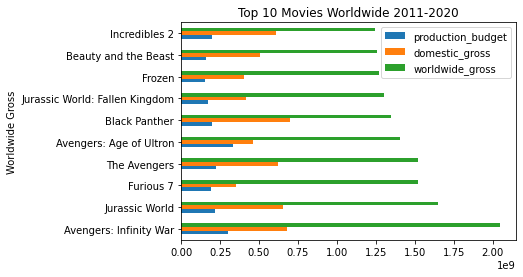

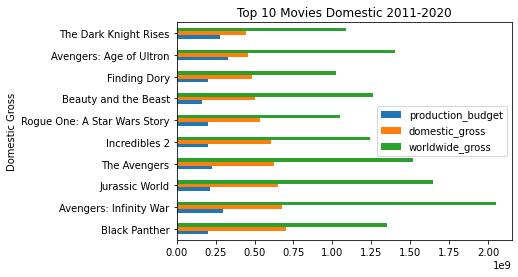

In [47]:
ax1 = top10_worldwide.set_index('movie').plot(kind='barh')
ax2 = top10_domestic.set_index('movie').plot(kind='barh')

ax1.set_ylabel("Worldwide Gross")
ax2.set_ylabel("Domestic Gross")
ax1.set_title("Top 10 Movies Worldwide 2011-2020")
ax2.set_title("Top 10 Movies Domestic 2011-2020");

In [48]:
###Exploring name dataframe
name.head(2)

,primary_name,primary_profession,known_for_titles
0,Mary Ellen Bauder,"[miscellaneous, production_manager, producer]","[tt0837562, tt2398241, tt0844471, tt0118553]"
1,Joseph Bauer,"[composer, music_department, sound_department]","[tt0896534, tt6791238, tt0287072, tt1682940]"


In [49]:
name = name.explode('known_for_titles')
name.head(2)

,primary_name,primary_profession,known_for_titles
0,Mary Ellen Bauder,"[miscellaneous, production_manager, producer]",tt0837562
0,Mary Ellen Bauder,"[miscellaneous, production_manager, producer]",tt2398241


In [50]:
top10_domestic.head(2)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,tconst,genres
25,"Feb 16, 2018",Black Panther,200000000,700059566,1348258224,2018,tt1825683,"[Action, Adventure, Sci-Fi]"
3,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,tt4154756,"[Action, Adventure, Sci-Fi]"


In [51]:
for names in name['known_for_titles']:
    if names.isin(top10_domestic['tconst']):
        print(names)
        

AttributeError: 'str' object has no attribute 'isin'

### Requirements: import, clean, combine, reshape, and visualize data to answer questions

#### 1. Load the Data with Pandas

Create a dataframes `df1` and `df2` etc. that represent the files. Use pandas methods to inspect the shape and other attributes of these dataframes.

#### 2. Perform Data Aggregation and Data Cleaning Required to Answer Question

The question is: Is there any particular director/producer who appears frequently in the top 50 movies over the past 10 years? Perhaps, recruit them if they are popular;)

(with Jesus' question#1) use: rt.movie_info.tsv.gz   OR  imdb.title.crew.csv.gz   OR   imdb.name.basics.csv.gz

In order to answer this question, you will need to:

* Join the dataframes together
* Identify and handle missing values, invalid values
* Identify and handle text data requiring cleaning